In [1]:
# Check Pytorch installation
import torch, torchvision
print("torch version:",torch.__version__, "cuda:",torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print("mmdetection:",mmdet.__version__)

# Check mmcv installation
import mmcv
print("mmcv:",mmcv.__version__)

# Check mmengine installation
import mmengine
print("mmengine:",mmengine.__version__)

torch version: 2.0.1 cuda: True
mmdetection: 3.1.0
mmcv: 2.0.1
mmengine: 0.8.4


In [13]:
%cd mmdetection

e:\Dataset\Python\Environment\mmdetection


In [17]:
from mmengine import Config
cfg = Config.fromfile('E:/Dataset/Python/Environment/mmdetection/configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-1x_coco.py')

In [18]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('field', ),
    'palette': [
        (220, 20, 60),
    ]
}

# Modify dataset type and path
cfg.data_root = 'E:/Dataset/fielddatasets/field'

cfg.train_dataloader.dataset.ann_file = 'train/annotation_coco.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'val/annotation_coco.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'val/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'val/annotation_coco.json'
cfg.test_evaluator = cfg.val_evaluator

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = 'E:/Dataset/Border_separate/rtmdet-ins_l_8xb32-300e_coco_20221124_103237-78d1d652.pth'

# Set up working dir to save files and logs.
cfg.work_dir = 'E:/Dataset/Border_separate/work_dir/Project24Jan2024'


# We can set the evaluation interval to reduce the evaluation times
cfg.train_cfg.val_interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 3

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10


# Set seed thus the results are more reproducible
# cfg.seed = 0
set_random_seed(0, deterministic=False)

# We can also use tensorboard to log the training process
#cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------
config=f'E:/Dataset/Border_separate/rtmdet-ins_l_1xb4-100e_ballon.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [19]:
!python tools/train.py {config}

01/24 18:48:02 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:34:57) [MSC v.1936 64 bit (AMD64)]
    CUDA available: True
    numpy_random_seed: 302863982
    GPU 0: NVIDIA GeForce RTX 3060
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: n/a
    PyTorch: 2.0.1
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,cod

In [23]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
# Choose to use a config and initialize the detector
config_file = 'E:/Dataset/Border_separate/rtmdet-ins_l_1xb4-100e_ballon.py'
# Setup a checkpoint file to load
checkpoint_file = 'E:/Dataset/Border_separate/work_dir/Project24Jan2024/epoch_12.pth'

# register all modules in mmdet into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cuda:0'

Loads checkpoint by local backend from path: E:/Dataset/Border_separate/work_dir/Project24Jan2024/epoch_12.pth


In [29]:
# Use the detector to do inference
image = mmcv.imread('E:/Dataset/fielddatasets/field/test/field0010.jpeg',channel_order='rgb')
result = inference_detector(model, image)

In [30]:
from mmdet.registry import VISUALIZERS
# init visualizer(run the block only once in jupyter notebook)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta

e:\Dataset\Python\Environment\.conda\lib\site-packages\mmengine\utils\manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


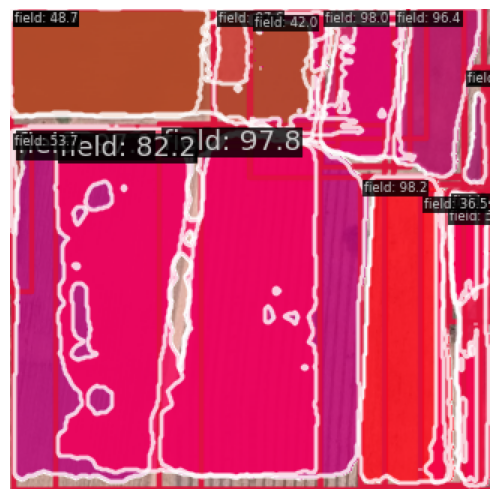

In [31]:
# show the results
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt = None,
    wait_time=0,
)
visualizer.show()